## Demo

In [89]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
import os
import json
import glob


import numpy as np
import pandas as pd
import sklearn.metrics
import sklearn.model_selection
import torch 
import torchvision
import rasterio as rio
import matplotlib.pyplot as plt
import torchinfo
from torch.utils.tensorboard import SummaryWriter

from models.from_config import build_from_config
from data_handlers.csv_dataset import CustomDatasetFromDataFrame
from utils import utils
from train import train
from test import test

In [37]:
CSV_PATH=os.path.join('data','geometry_less_dataset.csv')
DATA_DIR=os.path.join('data','landsat_tif','')

In [91]:
# Add filenames:
csv = pd.read_csv(CSV_PATH)
csv['filename']=csv.apply(
    lambda row:  str(row['lat'])[:5].replace('.','_')+"_"+str(row.lon)[:5].replace('.','_')+'.tif', axis=1
)
csv = csv.loc[:, ~csv.columns.str.contains('^Unnamed')]
csv.head()

,country,year,cluster,lat,lon,households,wealthpooled,filename
0,angola,2011,1,-12.350257,13.534922,36,2.312757,-12_3_13_53.tif
1,angola,2011,2,-12.360865,13.551494,32,2.010293,-12_3_13_55.tif
2,angola,2011,3,-12.613421,13.413085,36,0.877744,-12_6_13_41.tif
3,angola,2011,4,-12.581454,13.397711,35,1.066994,-12_5_13_39.tif
4,angola,2011,5,-12.578135,13.418748,37,1.750153,-12_5_13_41.tif


In [92]:
# AND SAVE UPDATED CSV
# csv.to_csv(CSV_PATH, index=False)
# def show_sample(tile, label, swap_br=True):
#     tile_rgb = tile[:3,:,:].numpy()
#     tile_rgb = tile_rgb.transpose((1,2,0))
#     tile_rgb = (tile_rgb-tile_rgb.min() )/ (tile_rgb.max()-tile_rgb.min())
#     print(tile_rgb.min(), " __ ", tile_rgb.max())
#     if swap_br:
#         tile_rgb=tile_rgb[:,:,::-1]
#     plt.figure()
#     plt.imshow((tile_rgb*255).astype(int))
#     plt.title('wealth index: '+str(label))
#     plt.show()
#     return

In [93]:
train_transform = torch.nn.Sequential(
    torchvision.transforms.Resize(size=224),
    torchvision.transforms.CenterCrop(size=224),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.Normalize(
        mean=[42.7178, 42.9092, 43.2119, 42.8700, 42.7862, 42.7192, 42.8525],
        std =[104.3150, 104.7388, 105.4271, 104.6307, 104.5374, 104.3182, 104.5891]
        ),
    torchvision.transforms.ColorJitter(),
)
test_transform  = torch.nn.Sequential(
    torchvision.transforms.Resize(size=224),
    torchvision.transforms.CenterCrop(size=224),
    torchvision.transforms.Normalize(
        mean=[42.7178, 42.9092, 43.2119, 42.8700, 42.7862, 42.7192, 42.8525],
        std =[104.3150, 104.7388, 105.4271, 104.6307, 104.5374, 104.3182, 104.5891]
        ),
)

In [94]:
cluster_splits = sklearn.model_selection.train_test_split(np.arange(len(csv.cluster.unique())))
# train test split
train_split = np.array([idx for i in cluster_splits[0] for idx,_ in csv[csv.cluster==i].iterrows()])
test_split  = np.array([idx for i in cluster_splits[1] for idx,_ in csv[csv.cluster==i].iterrows()])[0:1000]
# train val split
np.random.shuffle(train_split)
train_split, val_split = train_split[:int(0.8*len(train_split))], train_split[int(0.8*len(train_split)):]

In [95]:
CONFIG_FILE = 'configs/resnet18_ms_tl_l7_1e3.json'
with open( CONFIG_FILE ) as f:
    config = json.load(f)

In [96]:
train_df = csv.iloc[train_split]
val_df = csv.iloc[val_split]
test_df = csv.iloc[test_split]

train_dataset = CustomDatasetFromDataFrame(train_df, DATA_DIR, transform=train_transform)
val_dataset = CustomDatasetFromDataFrame(val_df, DATA_DIR, transform=train_transform)
test_dataset  = CustomDatasetFromDataFrame(test_df, DATA_DIR, transform=test_transform)

In [97]:
train_loader = torch.utils.data.DataLoader(
        train_dataset, 
        batch_size=config['batch_size'], 
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=4,
    pin_memory=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

2. Model Training Phase

In [98]:
import torchgeo.models
writer = SummaryWriter()

In [99]:
# TRANSFER LEARNING SCENARIO
base_model = torchgeo.models.resnet18(weights=torchgeo.models.ResNet18_Weights.SENTINEL2_ALL_MOCO)
model = build_from_config( base_model=base_model, config_file=CONFIG_FILE )
torchinfo.summary(
    model, 
    input_size=(int(config['batch_size']), 7, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
    verbose=0,
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [128, 7, 224, 224]   [128, 1]             --                   Partial
├─Conv2d (conv1)                         [128, 7, 224, 224]   [128, 64, 112, 112]  (21,952)             False
├─BatchNorm2d (bn1)                      [128, 64, 112, 112]  [128, 64, 112, 112]  (128)                False
├─ReLU (act1)                            [128, 64, 112, 112]  [128, 64, 112, 112]  --                   --
├─MaxPool2d (maxpool)                    [128, 64, 112, 112]  [128, 64, 56, 56]    --                   --
├─Sequential (layer1)                    [128, 64, 56, 56]    [128, 64, 56, 56]    --                   False
│    └─BasicBlock (0)                    [128, 64, 56, 56]    [128, 64, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [128, 64, 56, 56]    [128, 64, 56, 56]    (36,864)             False
│    │    

In [100]:
# CONFIGURE LOSS, OPTIM
loss_fn = utils.configure_loss( config )
optimizer = utils.configure_optimizer( config, model )
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [101]:
results = train(
    model=model,
    train_dataloader=val_loader,
    val_dataloader=test_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    loss_fn=loss_fn,
    epochs=config['n_epochs'],
    batch_size=config['batch_size'],
    in_channels=config['in_channels'],
    writer=writer,
    device=device
)
torch.save(model.state_dict(), config['checkpoint_path'])

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0699 | train_r2: -0.6718 | test_loss: 0.1000 | test_r2: 0.0000


  1%|          | 1/150 [08:12<20:23:35, 492.72s/it]

Epoch: 2 | train_loss: 0.0427 | train_r2: -0.0340 | test_loss: 0.0520 | test_r2: -0.2706


  1%|▏         | 2/150 [17:10<21:20:24, 519.09s/it]

Epoch: 3 | train_loss: 0.0422 | train_r2: -0.0202 | test_loss: 0.0520 | test_r2: -0.2706


  2%|▏         | 3/150 [24:36<19:50:30, 485.92s/it]

Epoch: 4 | train_loss: 0.0388 | train_r2: 0.0584 | test_loss: 0.0520 | test_r2: -0.2706


  3%|▎         | 4/150 [31:49<18:51:14, 464.90s/it]

Epoch: 5 | train_loss: 0.0391 | train_r2: 0.0553 | test_loss: 0.0520 | test_r2: -0.2706


  3%|▎         | 5/150 [39:26<18:36:50, 462.14s/it]

Epoch: 6 | train_loss: 0.0421 | train_r2: -0.0222 | test_loss: 0.0520 | test_r2: -0.2706


  4%|▍         | 6/150 [47:01<18:23:10, 459.66s/it]

Epoch: 7 | train_loss: 0.0399 | train_r2: 0.0343 | test_loss: 0.0441 | test_r2: -0.0681


  5%|▍         | 7/150 [55:52<19:10:52, 482.89s/it]

Epoch: 8 | train_loss: 0.0389 | train_r2: 0.0602 | test_loss: 0.0441 | test_r2: -0.0681


  5%|▌         | 8/150 [1:03:12<18:30:32, 469.25s/it]

In [ ]:
model.load_state_dict(torch.load(config['checkpoint_path']))
model = model.eval()

3. Test Results

In [ ]:
test_r2, Y_true, Y_pred = test(model=model, dataloader=val_loader, device=device)
# Y_true = [ utils.denormalize_asset(asset) for asset in Y_true]
# Y_pred = [ utils.denormalize_asset(asset) for asset in Y_pred]
results = pd.DataFrame({
    'true index':np.array(Y_true),
    'predicted index':np.array(Y_pred)
})
from scipy.stats import pearsonr
import seaborn as sns
sns.set_palette("rocket")
sns.regplot(x='true index', y='predicted index', data=results).set(title='R2 = '+str(test_r2))

### End-to-end training

In [ ]:
CONFIG_FILE = 'configs/resnet18_ms_e2e_l7_1e2.json'
with open( CONFIG_FILE ) as f:
    config = json.load(f)


train_loader = torch.utils.data.DataLoader(
        train_dataset, 
        batch_size=config['batch_size'], 
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=4,
    pin_memory=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=4,
    pin_memory=True
)
# MODEL
base_model = torchgeo.models.resnet18(weights=torchgeo.models.ResNet18_Weights.SENTINEL2_ALL_MOCO)
model = build_from_config( base_model=base_model, config_file=CONFIG_FILE )
torchinfo.summary(
    model, 
    input_size=(int(config['batch_size']), 7, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
    verbose=0,
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)
# CONFIGURE LOSS, OPTIM
loss_fn = utils.configure_loss( config )
optimizer = utils.configure_optimizer( config, model )
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer)
# TRAINING
results = train(
    model=model,
    train_dataloader=val_loader,
    val_dataloader=test_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    loss_fn=loss_fn,
    epochs=config['n_epochs'],
    batch_size=config['batch_size'],
    in_channels=config['in_channels'],
    writer=writer,
    device=device
)
torch.save(model.state_dict(), config['checkpoint_path'])

In [ ]:
model.load_state_dict(torch.load(config['checkpoint_path']))
model = model.eval()
test_r2, Y_true, Y_pred = test(model=model, dataloader=val_loader, device=device)
# Y_true = [ utils.denormalize_asset(asset) for asset in Y_true]
# Y_pred = [ utils.denormalize_asset(asset) for asset in Y_pred]
results = pd.DataFrame({
    'true index':np.array(Y_true),
    'predicted index':np.array(Y_pred)
})

[Text(0.5, 1.0, 'R2 = 0.04781018436651245')]

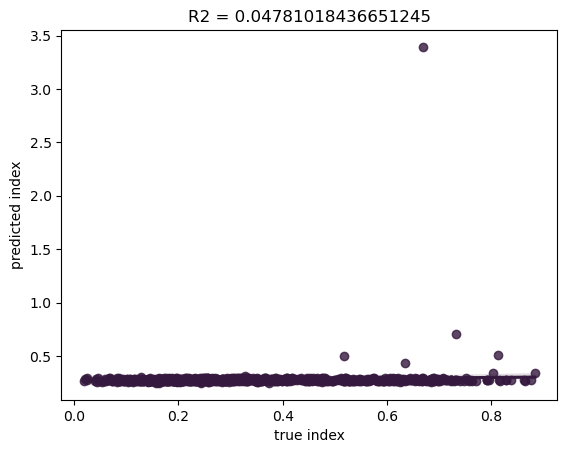

In [ ]:
from scipy.stats import pearsonr
import seaborn as sns
sns.set_palette("rocket")
sns.regplot(x='true index', y='predicted index', data=results).set(title='R2 = '+str(test_r2))